# Raisin Class Prediction EDA & ML (LogisticRegression, KNN)

Data Set Information:

Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.


Attribute Information:

1. Area: Gives the number of pixels within the boundaries of the raisin.
2. Perimeter: It measures the environment by calculating the distance between the boundaries of the raisin and the pixels around it.
3. MajorAxisLength: Gives the length of the main axis, which is the longest line that can be drawn on the raisin.
4. MinorAxisLength: Gives the length of the small axis, which is the shortest line that can be drawn on the raisin.
5. Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins.
6. ConvexArea: Gives the number of pixels of the smallest convex shell of the region formed by the raisin.
7. Extent: Gives the ratio of the region formed by the raisin to the total pixels in the bounding box.
8. Class: Kecimen and Besni raisin.

https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset

# Import libraries

In [71]:
!pip install plotly cufflinks

In [77]:
# libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf
#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.io as pio
pio.renderers.default = "vscode"
#To display the plots
%matplotlib inline
from ipywidgets import interact

# sklearn library for machine learning algorithms, data preprocessing, and evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score, accuracy_score, precision_score, f1_score

# yellowbrick library for visualizing the model performance
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer 

from sklearn.pipeline import Pipeline
# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [3]:
import sklearn
sklearn.__version__

'1.3.0'

## Exploratory Data Analysis and Visualization

In [4]:
df = pd.read_excel("Raisin_Dataset.xlsx") # Reading the dataset

In [5]:
df.head() 

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [7]:
df.shape

(900, 8)

In [8]:
df.duplicated().sum() #No duplicates

0

In [9]:
df.isnull().sum().any() #No missing values

False

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,900.0,87804.127778,39002.111390,25387.000000,59348.000000,78902.000000,105028.250000,235047.000000
MajorAxisLength,900.0,430.929950,116.035121,225.629541,345.442898,407.803951,494.187014,997.291941
MinorAxisLength,900.0,254.488133,49.988902,143.710872,219.111126,247.848409,279.888575,492.275279
Eccentricity,900.0,0.781542,0.090318,0.348730,0.741766,0.798846,0.842571,0.962124
ConvexArea,900.0,91186.090000,40769.290132,26139.000000,61513.250000,81651.000000,108375.750000,278217.000000
Extent,900.0,0.699508,0.053468,0.379856,0.670869,0.707367,0.734991,0.835455
Perimeter,900.0,1165.906636,273.764315,619.074000,966.410750,1119.509000,1308.389750,2697.753000


Class
Kecimen    0.5
Besni      0.5
Name: proportion, dtype: float64


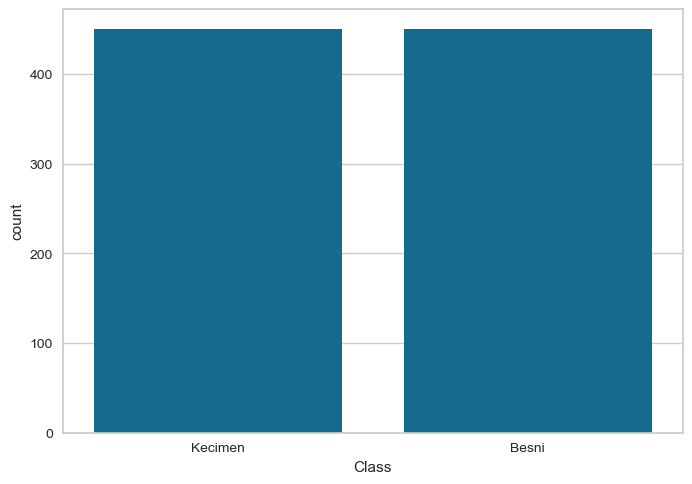

In [11]:
print(df["Class"].value_counts(normalize=True)) # to show the proportion of each class
sns.countplot(data = df, x = "Class");

We have prety same amout of classes in the data set. So I can use accuracy as a metric to evaluate the performance of the classifier.

In [12]:
df["Class"] = df["Class"].map({"Kecimen":0,"Besni":1}) # mapping the classes to 0 and 1

In [78]:
#featurewise box plot  
df.iloc[:,:-1].iplot(kind="box")

In [79]:
#  featurewise box plot with classess
fig = px.box(df, color="Class", color_discrete_map={"Kecimen":'#FF0000',"Besni":'#00FF00'})
fig.show()

In [80]:
df.iloc[:,:-1].iplot(kind="hist")

In [81]:
def histogramer(feature,bins):
    fig = px.histogram(df,x=feature,color="Class",
                   histfunc="avg",nbins=bins,
                   color_discrete_map={"Kecimen":'#FF0000',"Besni":'#00FF00'})
    fig.show()

cols = df.columns 
interact(histogramer, feature = cols,bins=125)

interactive(children=(Dropdown(description='feature', options=('Area', 'MajorAxisLength', 'MinorAxisLength', '…

<function __main__.histogramer(feature, bins)>

<Axes: >

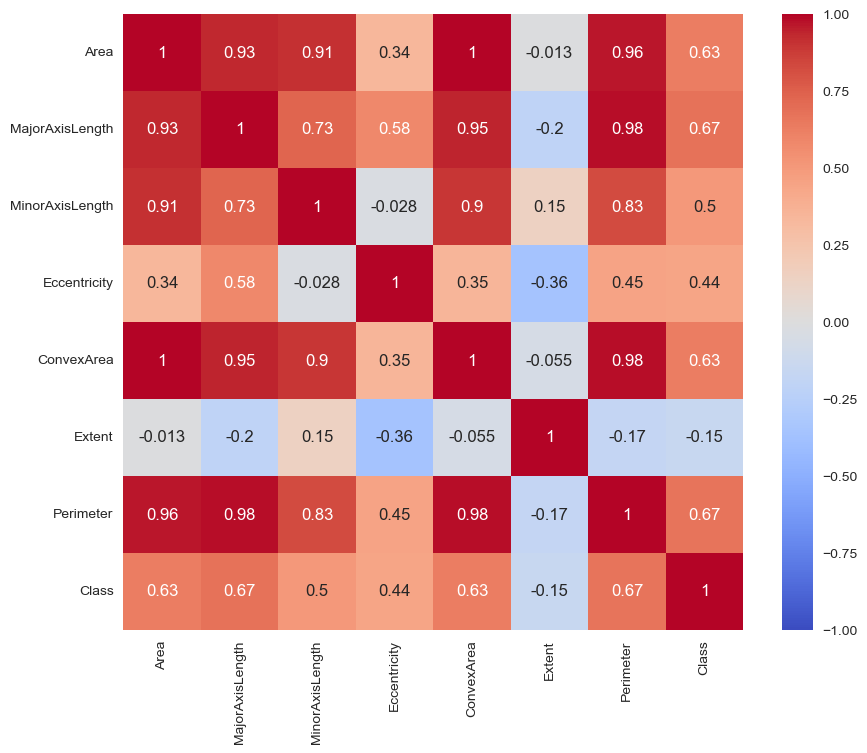

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(),vmin=-1,vmax=1, annot=True, cmap='coolwarm')

In [82]:
corr_matrix = df.corr()
fig = px.imshow(corr_matrix)
fig.show()

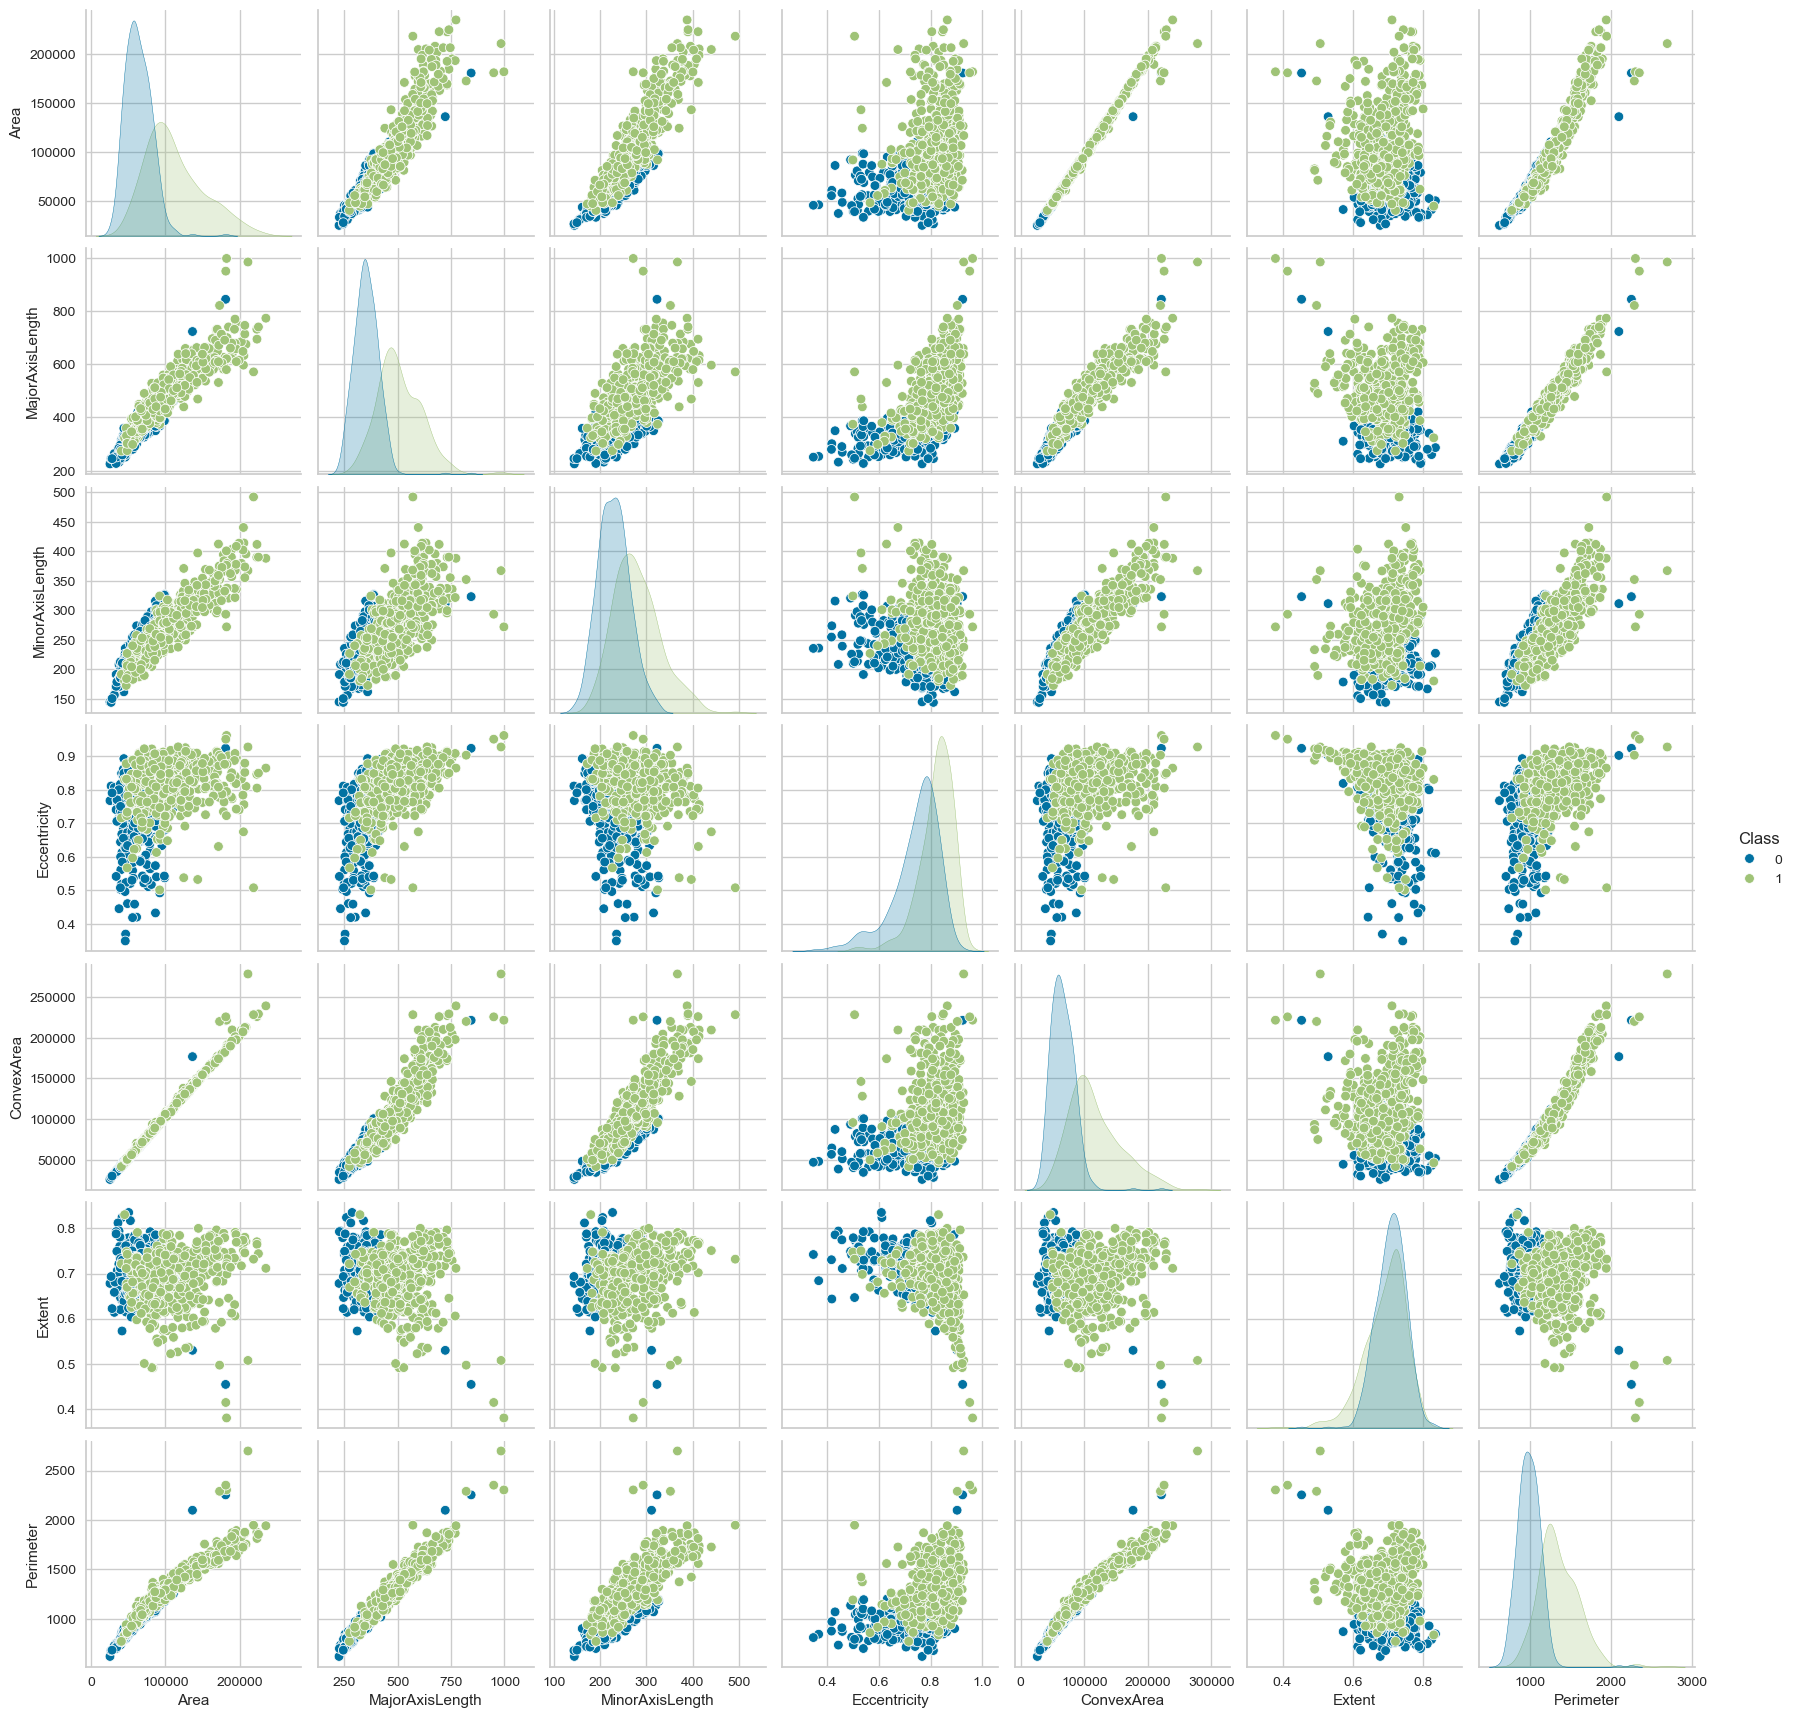

In [19]:
sns.pairplot(df, hue = "Class")

In [83]:
def scatter_3D(xx,yy,zz):
    fig = px.scatter_3d(df, x=xx, y=yy, z=zz,
                        color='Class', )
    fig.show()
    
    
cols = df.columns    
interact(scatter_3D, xx=cols,yy=cols,zz=cols)

interactive(children=(Dropdown(description='xx', options=('Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccen…

<function __main__.scatter_3D(xx, yy, zz)>

## Train | Test Split and Scaling

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 56.4 KB


In [22]:
X=df.drop(["Class"], axis=1)
y=df["Class"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=10)

In [24]:
scaler =StandardScaler() # will be used in the pipelines

# Logistic Regression

In [25]:
log_model = LogisticRegression() # will be used in the pipelines

In [26]:
log_pipe = Pipeline([("scaler",scaler),("log_model",log_model)]) # pipeline for logistic regression

In [27]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_model', LogisticRegression())])

In [28]:
y_pred=log_pipe.predict(X_test)

In [29]:
y_pred_proba = log_pipe.predict_proba(X_test)

## Model Performance

In [30]:
def eval_metric(model, X_train, y_train, X_test, y_test):

    """ to get the metrics for the model """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [31]:
eval_metric(log_pipe, X_train, y_train, X_test, y_test) # to get the metrics for the model

Test_Set
[[81  9]
 [14 76]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        90
           1       0.89      0.84      0.87        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Train_Set
[[317  43]
 [ 53 307]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.88      0.85      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



### Cross Validate

In [32]:
model = Pipeline([("scaler",scaler),("log_model",log_model)])

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10,error_score="raise")
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
1,0.015365,0.011156,0.935484,0.805556,0.865672,0.875000
2,0.015693,0.014876,0.857143,0.833333,0.845070,0.847222
3,0.004229,0.015627,0.842105,0.888889,0.864865,0.861111
4,0.015663,0.000000,0.767442,0.916667,0.835443,0.819444
5,0.015596,0.016052,0.933333,0.777778,0.848485,0.861111
6,0.000000,0.015680,0.903226,0.777778,0.835821,0.847222
7,0.000000,0.015589,0.942857,0.916667,0.929577,0.930556
8,0.015616,0.015628,0.804878,0.916667,0.857143,0.847222
9,0.015625,0.000000,0.857143,0.833333,0.845070,0.847222
10,0.021133,0.010510,0.967742,0.833333,0.895522,0.902778


In [33]:
df_scores.mean()[2:]     

test_precision    0.881135
test_recall       0.850000
test_f1           0.862267
test_accuracy     0.863889
dtype: float64

### GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV
# pipeline for logistic regression
model = Pipeline([("scaler",scaler),("log_model",log_model)]) 
# l1: Lasso, l2: Ridge
penalty = ["l1", "l2"] 
# to get 20 values of C between -1 and 5
C = np.logspace(-1, 5, 20) 
# balanced: class weights are balanced, None: no class weights
class_weight= ["balanced", None] 
# to get 4 values of solver
solver = ["lbfgs", "liblinear", "sag", "saga"] 
# to get all the combinations of penalty, C, class_weight and solver
param_grid = {"log_model__penalty" : penalty,
              "log_model__C" : [C,1],
              "log_model__class_weight":class_weight,
              "log_model__solver":solver} 

# to get the best model
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = 'accuracy',       
                          n_jobs = -1) 

In [35]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_model__C': [array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                                          1],
                         'log_model__class_weight': ['balanced', None],
                         'log_model__penalty': ['l1', 'l2'],
                         'log_model__solver': ['lbfgs', 'liblinear', 'sag',
                                               'saga']},
             scoring='accuracy')

In [36]:
grid_model.best_params_ # to get the best parameters according to the best score

{'log_model__C': 1,
 'log_model__class_weight': 'balanced',
 'log_model__penalty': 'l1',
 'log_model__solver': 'liblinear'}

In [37]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)  

# test set accuracy increased 0.87 to 0.88

Test_Set
[[79 11]
 [10 80]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        90
           1       0.88      0.89      0.88        90

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[316  44]
 [ 53 307]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.87      0.85      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report,\
                            accuracy_score, recall_score, precision_score,f1_score,\
                            precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay,\
                            roc_auc_score, roc_curve, average_precision_score


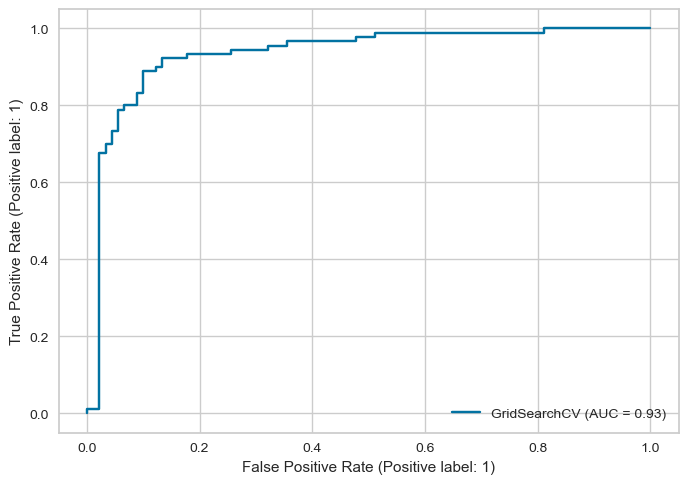

In [39]:
#roc_auc_score(grid_model, X_test, y_test) # we use ROC curve to get the AUC score and evaluate the model if it is good or not on every threshold
RocCurveDisplay.from_estimator(grid_model, X_test, y_test)

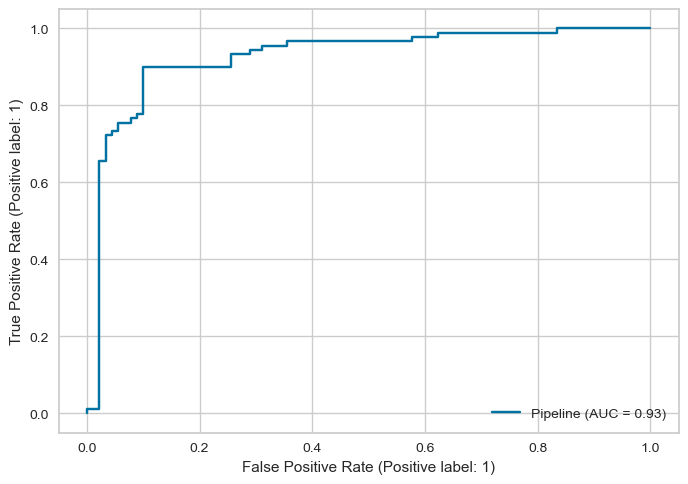

In [40]:
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test) 

## KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier()  # to get a object of KNeighborsClassifier for pipeline

In [43]:
knn_pipe = Pipeline([("scaler",scaler),("knn",knn)]) # pipeline for KNeighborsClassifier

In [44]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [45]:
knn_pred = knn_pipe.predict(X_test)

In [46]:
eval_metric(knn_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[80 10]
 [16 74]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        90
           1       0.88      0.82      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180


Train_Set
[[332  28]
 [ 55 305]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       360
           1       0.92      0.85      0.88       360

    accuracy                           0.88       720
   macro avg       0.89      0.88      0.88       720
weighted avg       0.89      0.88      0.88       720



### Elbow Method for Choosing Reasonable K Values

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [48]:
test_error_rates = []


for k in range(1,30):

    model = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=k))]) # p=1,weights="uniform",metric="minkowski"

    scores = cross_validate(model, X_train, y_train, scoring = ['accuracy'], cv = 10,error_score="raise")
    
    accuracy_mean = scores["test_accuracy"].mean() 
    
    
    test_error = 1 - accuracy_mean 
    test_error_rates.append(test_error)

In [49]:
test_error_rates1 = []


for k in range(1,30):
    knn_model = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=k))])
    knn_model.fit(X_train,y_train) 
   
    y_pred_test = knn_model.predict(X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates1.append(test_error)

Text(0, 0.5, 'Error Rate')

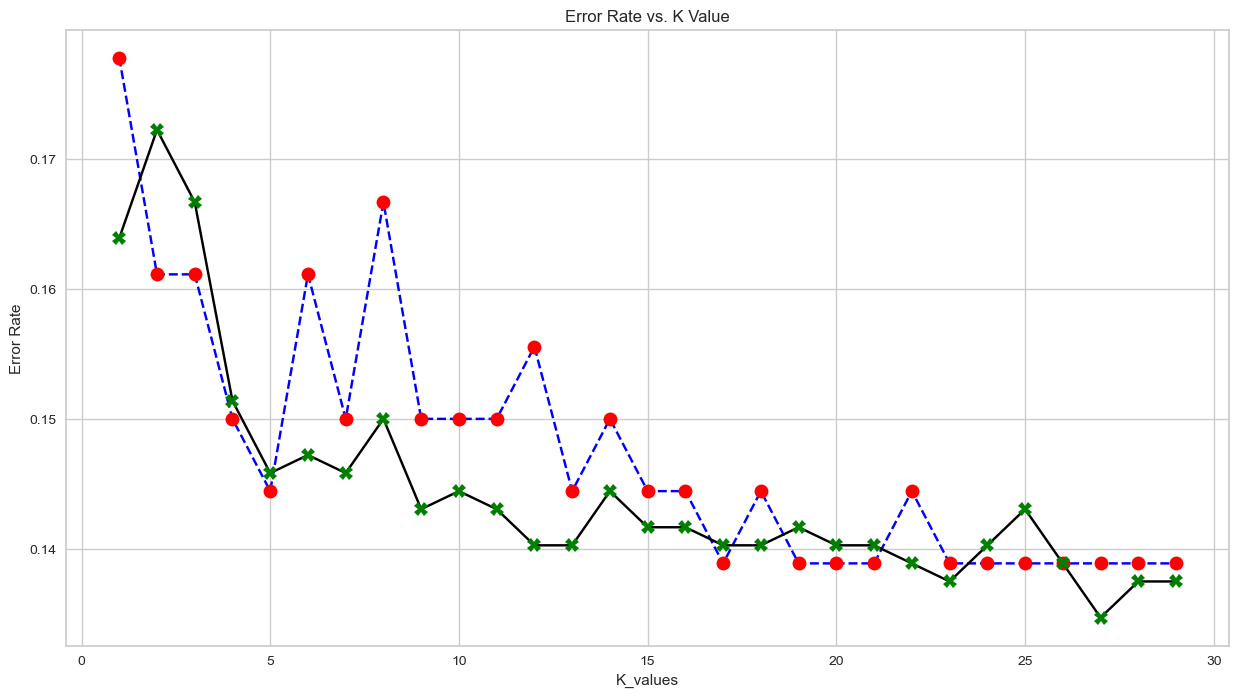

In [50]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates1, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.plot(range(1,30), test_error_rates, color='black', linestyle='-', marker='X',
         markerfacecolor='green', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')

### Scores by Various K Values

In [51]:
knn = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=2))])
knn.fit(X_train,y_train)
print('WITH K=2\n')
eval_metric(knn, X_train, y_train, X_test, y_test)  

WITH K=2

Test_Set
[[82  8]
 [21 69]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        90
           1       0.90      0.77      0.83        90

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180


Train_Set
[[360   0]
 [ 60 300]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       360
           1       1.00      0.83      0.91       360

    accuracy                           0.92       720
   macro avg       0.93      0.92      0.92       720
weighted avg       0.93      0.92      0.92       720



In [52]:
knn = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=8))])

knn.fit(X_train,y_train)
print('WITH K=8\n')
eval_metric(knn, X_train, y_train, X_test, y_test)  

WITH K=8

Test_Set
[[81  9]
 [21 69]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        90
           1       0.88      0.77      0.82        90

    accuracy                           0.83       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.83      0.83       180


Train_Set
[[338  22]
 [ 68 292]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       360
           1       0.93      0.81      0.87       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.87       720
weighted avg       0.88      0.88      0.87       720



In [53]:
knn = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=25))])

knn.fit(X_train,y_train)
print('WITH 25K=\n')
eval_metric(knn, X_train, y_train, X_test, y_test)

WITH 25K=

Test_Set
[[81  9]
 [16 74]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        90
           1       0.89      0.82      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180


Train_Set
[[326  34]
 [ 63 297]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       360
           1       0.90      0.82      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



In [54]:
knn = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=5))])   
knn.fit(X_train,y_train)
print('WITH 5K=\n')
eval_metric(knn, X_train, y_train, X_test, y_test)

WITH 5K=

Test_Set
[[80 10]
 [16 74]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        90
           1       0.88      0.82      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180


Train_Set
[[332  28]
 [ 55 305]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       360
           1       0.92      0.85      0.88       360

    accuracy                           0.88       720
   macro avg       0.89      0.88      0.88       720
weighted avg       0.89      0.88      0.88       720



### Cross Validate

In [55]:
model =Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=5))])

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
1,0.015634,0.021676,0.962963,0.722222,0.825397,0.847222
2,0.006292,0.014766,0.862069,0.694444,0.769231,0.791667
3,0.004005,0.006238,0.833333,0.833333,0.833333,0.833333
4,0.000000,0.015671,0.794872,0.861111,0.826667,0.819444
5,0.000000,0.025710,0.965517,0.777778,0.861538,0.875000
6,0.000000,0.020861,0.909091,0.833333,0.869565,0.875000
7,0.006044,0.010012,0.882353,0.833333,0.857143,0.861111
8,0.000000,0.015639,0.882353,0.833333,0.857143,0.861111
9,0.015621,0.008169,0.861111,0.861111,0.861111,0.861111
10,0.000000,0.015691,1.000000,0.833333,0.909091,0.916667


In [56]:
df_scores.mean()[2:]        

test_precision    0.895366
test_recall       0.808333
test_f1           0.847022
test_accuracy     0.854167
dtype: float64

In [57]:
knn = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier(n_neighbors=5))])   # test_accuracy:    0.86 , train_accuracy :  0.88
                                              
                                                                                  # test_accuracy     0.85  (cross validation)
                                            
                                                                                  # (k=5 with elbow) with 26 wrong prediction
knn.fit(X_train,y_train)
print('WITH K=5\n')
eval_metric(knn, X_train, y_train, X_test, y_test)  

WITH K=5

Test_Set
[[80 10]
 [16 74]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        90
           1       0.88      0.82      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180


Train_Set
[[332  28]
 [ 55 305]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       360
           1       0.92      0.85      0.88       360

    accuracy                           0.88       720
   macro avg       0.89      0.88      0.88       720
weighted avg       0.89      0.88      0.88       720




### Gridsearch Method for Choosing Reasonable K Values

In [58]:
# pipeline for KNeighborsClassifier
knn_grid = Pipeline([("scaler",scaler),("knn",KNeighborsClassifier())]) 
# to get all the values of k between 1 and 30
k_values= range(1,30) 
# to get the values of weight
weight = ['uniform', 'distance'] 
# to get the values of p
p = [1,2] 
# to get the values of metric
metric = ['minkowski'] 
# to get all the combinations of k, weight, p and metric
param_grid = {'knn__n_neighbors': k_values,
              'knn__weights': weight, 
              'knn__p': p, 
              'knn__metric': metric} 
# to get the best model according to the best score
knn_grid_model = GridSearchCV(estimator= knn_grid, 
                             param_grid=param_grid,
                             cv=10, 
                             scoring= 'accuracy',
                             n_jobs=-1) 

In [59]:
knn_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['minkowski'],
                         'knn__n_neighbors': range(1, 30), 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [60]:
knn_grid_model.best_params_ # to get the best parameters according to the best score

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 14,
 'knn__p': 1,
 'knn__weights': 'uniform'}

In [61]:
print('WITH K=14\n')      #  knn      test_accuracy :   0.85  (k=14 with gridsearch) with 27 wrong prediction

                          #  knn      test_accuracy :   0.86  (k=5 with elbow) with 26 wrong prediction
eval_metric(knn_grid_model, X_train, y_train, X_test, y_test)

WITH K=14

Test_Set
[[81  9]
 [18 72]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        90
           1       0.89      0.80      0.84        90

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180


Train_Set
[[334  26]
 [ 66 294]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       360
           1       0.92      0.82      0.86       360

    accuracy                           0.87       720
   macro avg       0.88      0.87      0.87       720
weighted avg       0.88      0.87      0.87       720



### Evaluating ROC Curves and AUC

In [62]:
model = KNeighborsClassifier(n_neighbors=14, p=1, metric="minkowski", weights="uniform") # best gridsearch model
 
knn_model = Pipeline([("scaler",scaler),("knn",model)])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=14, p=1))])

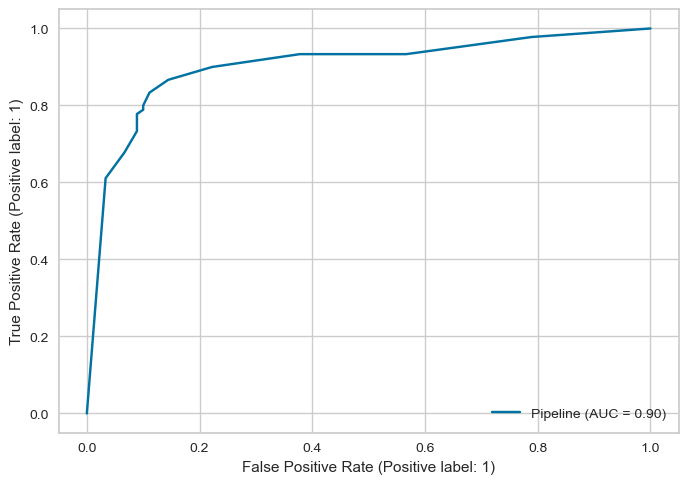

In [63]:
RocCurveDisplay.from_estimator(knn_model, X_test, y_test)

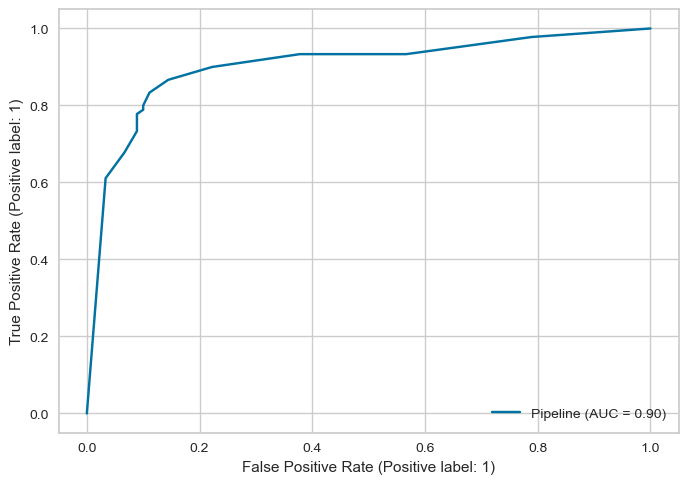

In [64]:
# 0.85  (k=14 with gridsearch) with 27 wrong prediction
RocCurveDisplay.from_estimator(knn_model, X_test, y_test) 

In [65]:
y_pred_proba = knn_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

0.9021604938271606

In [66]:
model = KNeighborsClassifier(n_neighbors=5) # best elbow model

knn_model = Pipeline([("scaler",scaler),("knn",model)])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

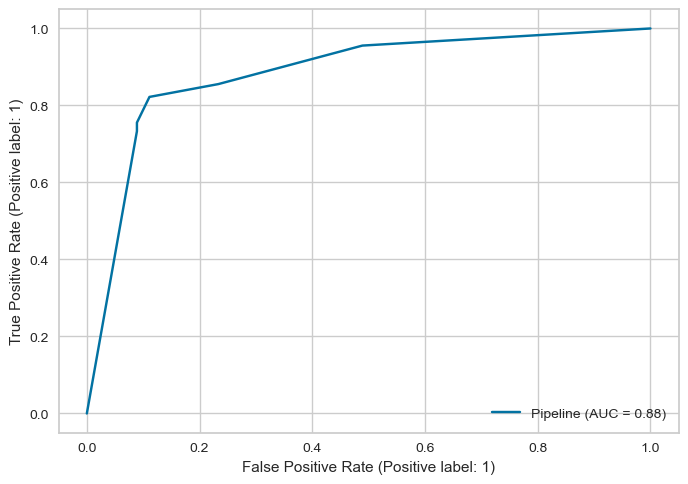

In [67]:
#  knn test_accuracy :   0.86  (k=5 with elbow)  with 26 wrong prediction
RocCurveDisplay.from_estimator(knn_model, X_test, y_test)  

# Conclusion 

* log_model Accuracy Score: 0.88 
* log_model AUC : 0.93           

* knn Accuracy Score :   0.86  (k=5 with elbow)  - 0.85  (k=14 with gridsearch)
* knn AUC : 0.88 (elbow) - 0.90 (gridsearch)

* As a conclusion we aplied two models to predict raisins classes and we got prety decent scores both of them
* We decided to use the Logistic Model because of its slightly better score than the knn models, plus the interpretability of logistic regression and its lower computational cost.

END OF THE PROJECT